In [46]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy import stats
from pandas.api.types import is_numeric_dtype
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

### Chargement des fichiers

In [47]:
customers = pd.read_csv("archive/olist_customers_dataset.csv", sep=",")
geolocation = pd.read_csv("archive/olist_geolocation_dataset.csv", sep=",")
order_items = pd.read_csv("archive/olist_order_items_dataset.csv", sep=",")
order_payments = pd.read_csv("archive/olist_order_payments_dataset.csv",
                             sep=",")
order_reviews = pd.read_csv("archive/olist_order_reviews_dataset.csv", sep=",")
orders = pd.read_csv("archive/olist_orders_dataset.csv", sep=",")
products = pd.read_csv("archive/olist_products_dataset.csv", sep=",")
sellers = pd.read_csv("archive/olist_sellers_dataset.csv", sep=",")

if not os.path.exists('P5_cleaning'):
    os.makedirs('P5_cleaning')

In [48]:
print(len(orders.customer_id.unique()))
print(len(customers.customer_unique_id.unique()))
# 99 000 customers ID uniques pour les commandes
# mais 96 000 customer Unique Id uniques pour les clients donc 3% de gens qui font plus d'une commande

99441
96096


### Petite exploration des données

In [49]:
nbr_items = order_items.groupby(
    by=['order_id']).count()['order_item_id'].rename("nbr_items")
total_pay = order_payments.groupby(
    by=['order_id']).sum()['payment_value'].rename("total_pay")
nbr_types = order_items.groupby(
    by=['order_id']).nunique()['order_item_id'].rename("nbr_types")
order_reviews.set_index('order_id', inplace=True, drop=True)

df_allData = orders.set_index(
    'order_id',
    drop=True).join(total_pay).join(nbr_items).join(nbr_types).join(
        order_reviews[['review_score']]).reset_index()
df_allData = df_allData.merge(customers, on=['customer_id'])

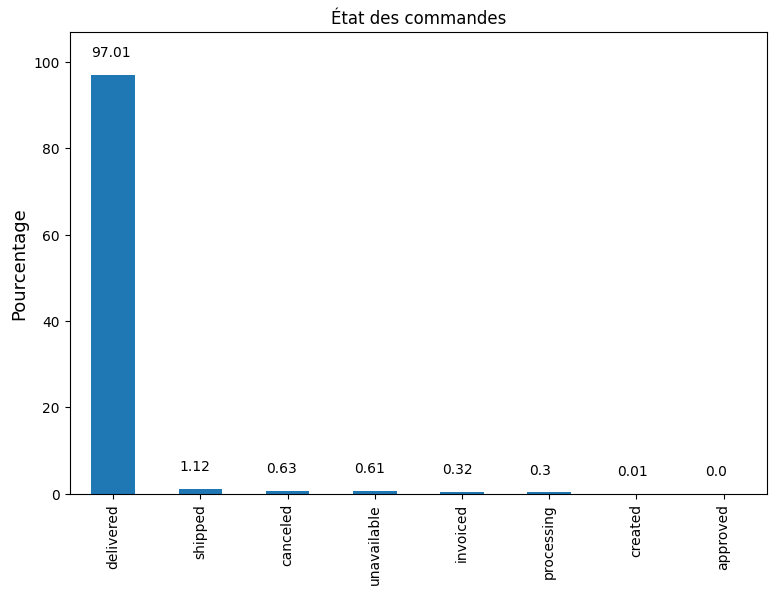

In [50]:
status = df_allData.order_status.value_counts() / df_allData.shape[0] * 100

fig, ax = plt.subplots(figsize=(9, 6))

status.plot(kind='bar')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(), decimals=2),
                (p.get_x() * 1.005, p.get_height() +2),
                va='center',
                xytext=(0, 10),
                textcoords='offset points',
                )
plt.title("État des commandes")
plt.ylim([0,107])
plt.ylabel('Pourcentage', fontsize=13)

plt.savefig("P5_cleaning/etat_des_commandes.png", bbox_inches='tight')
#pourcentage des statuts, à voir si je peux les écrire au dessus des bars

In [51]:
purchases = pd.to_datetime(df_allData.order_purchase_timestamp).dt.date
# dt.date pour avoir la partie date seulement des timestamp (dt.time pour avoir le temps / l'heure)

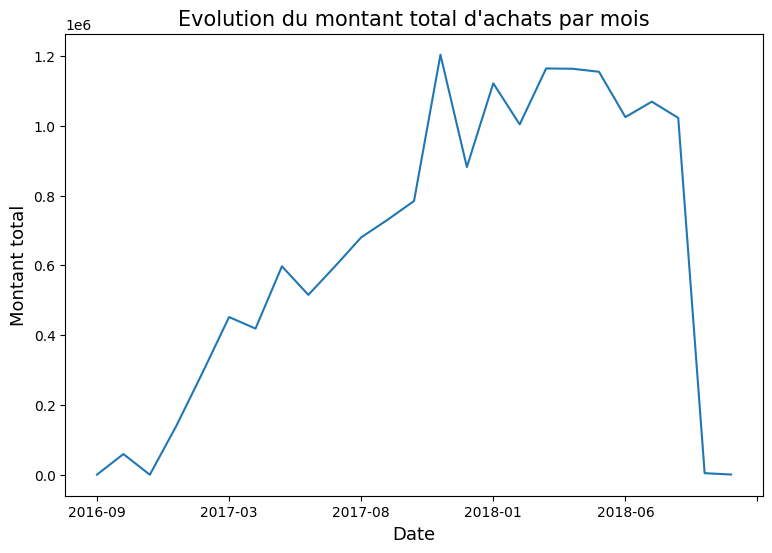

In [52]:
fig, ax = plt.subplots(figsize=(9, 6))

df_allData['purchases_month'] = pd.to_datetime(
    df_allData.order_purchase_timestamp).dt.to_period('M').astype(str)
df_allData.groupby('purchases_month').total_pay.sum().plot()
plt.title("Evolution du montant total d'achats par mois", fontsize=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Montant total', fontsize=13)
plt.savefig("P5_cleaning/montant_achats_par_mois.png", bbox_inches='tight')

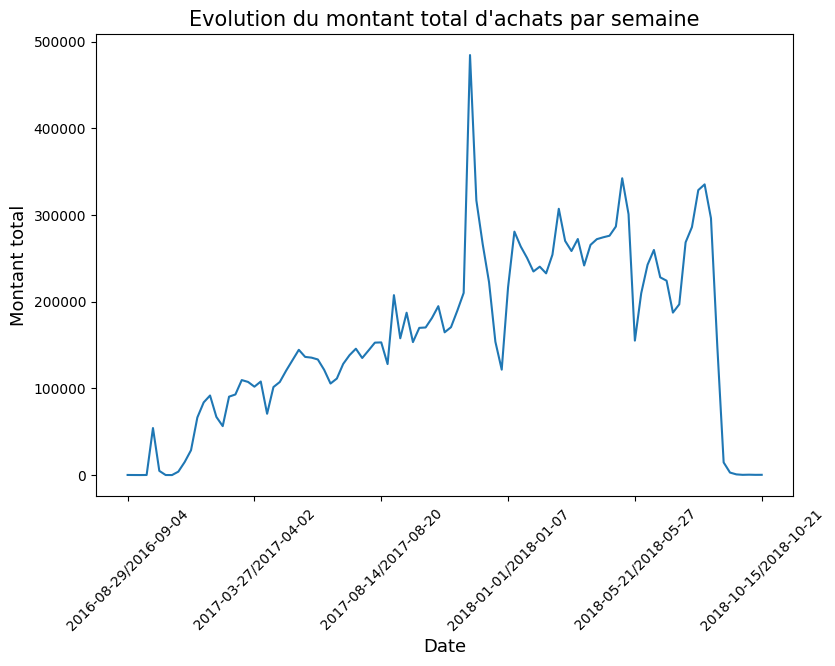

In [53]:
fig, ax = plt.subplots(figsize=(9, 6))

df_allData['purchases_week'] = pd.to_datetime(
    df_allData.order_purchase_timestamp).dt.to_period('W').astype(str)
df_allData.groupby('purchases_week').total_pay.sum().plot()

plt.title("Evolution du montant total d'achats par semaine", fontsize=15)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Montant total', fontsize=13)
plt.xticks(rotation=45)
plt.savefig("P5_cleaning/montant_achats_par_semaine.png", bbox_inches='tight')

In [54]:
nbr_orders = df_allData.groupby(
    by='customer_unique_id').nunique()['order_id'].rename('nbr_orders')
df_allData = df_allData.merge(nbr_orders, on='customer_unique_id')

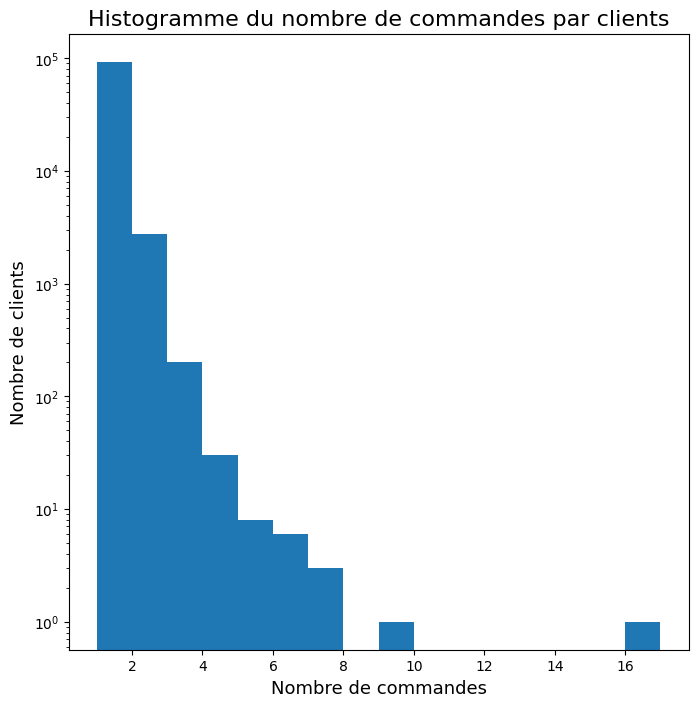

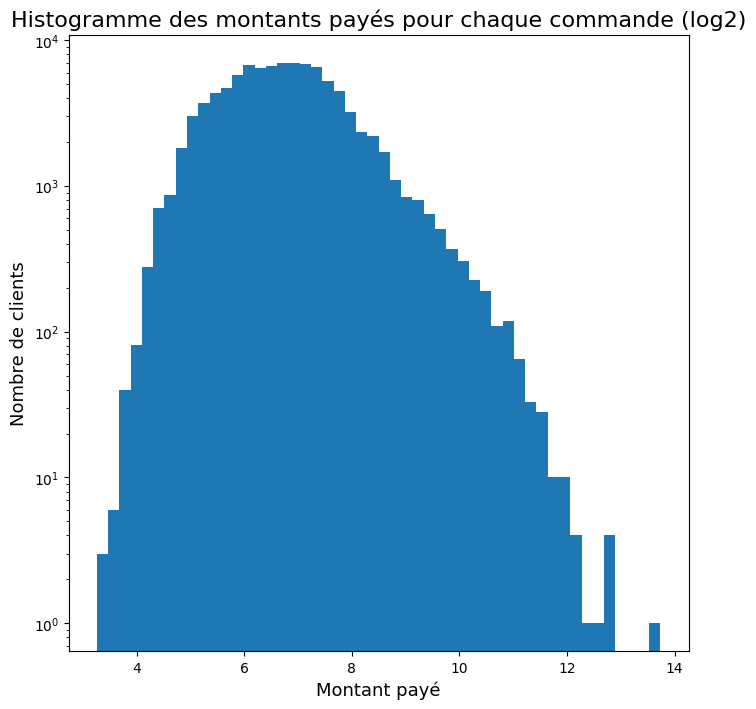

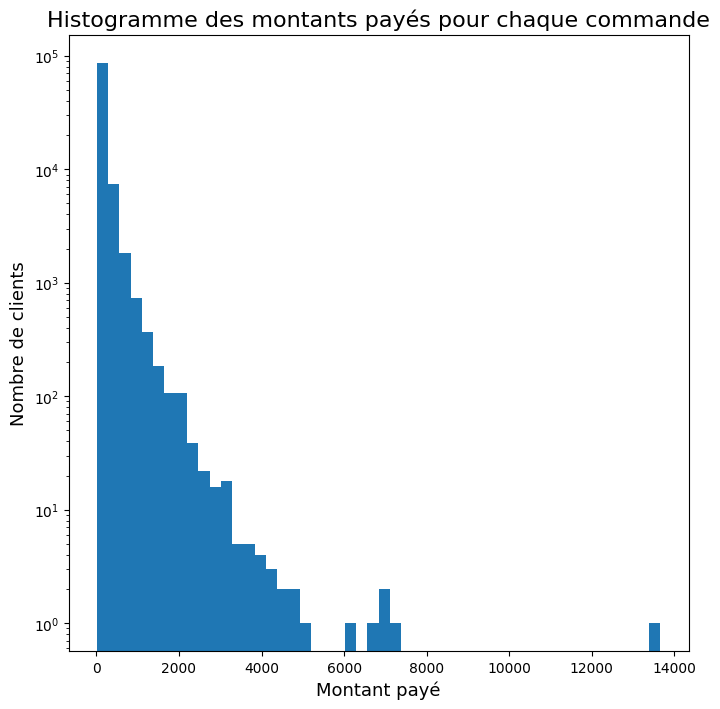

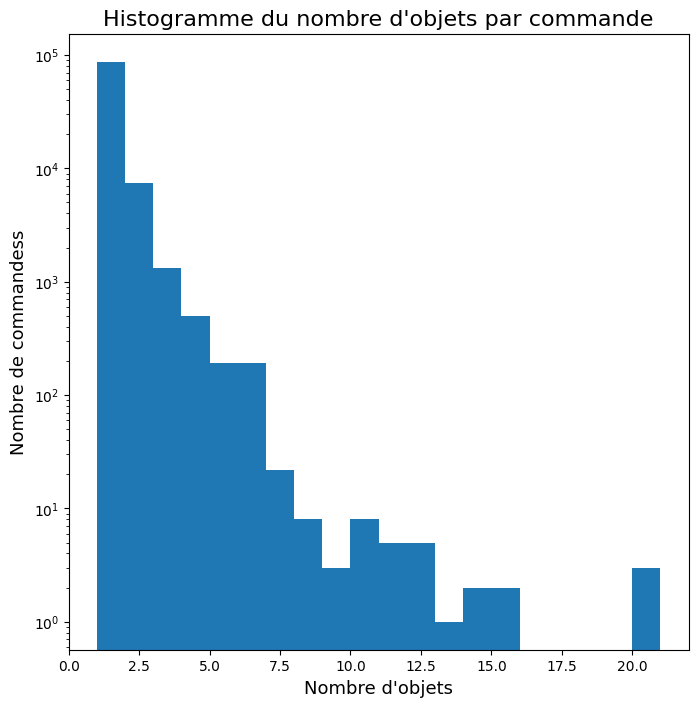

In [56]:
# histogramme du nbre de commandes
fig, ax = plt.subplots(figsize=(8, 8))
b = df_allData.drop_duplicates(subset="customer_unique_id")['nbr_orders']
fig = plt.hist(b, log=True, bins=range(1, 18))
ax.set_title('Histogramme du nombre de commandes par clients', size=16)
plt.xlabel('Nombre de commandes', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_nb_commandes.png", bbox_inches='tight')
plt.show()
plt.close()

# histogramme des montants payés pour chaque commande livrée; log 2
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = np.log2(
    df_allData[df_allData.order_status == 'delivered']['total_pay'])
plt.hist(df_delivered, log=True, bins=50)
ax.set_title('Histogramme des montants payés pour chaque commande (log2)', size=16)
plt.xlabel('Montant payé', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_montant_par_commande.png", bbox_inches='tight')
plt.show()
plt.close()

# histogramme des montants payés pour chaque commande livrée
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = df_allData[df_allData.order_status == 'delivered']['total_pay']
plt.hist(df_delivered, log=True, bins=50)
ax.set_title('Histogramme des montants payés pour chaque commande',
             size=16)
plt.xlabel('Montant payé', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_montant_par_commande_LOG.png",
            bbox_inches='tight')
plt.show()
plt.close()

# Nombre d'items par commandes
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = df_allData[df_allData.order_status == 'delivered']['nbr_items']
plt.hist(df_delivered, log=True, bins=20)
ax.set_title("Histogramme du nombre d'objets par commande", size=16)
plt.xlabel("Nombre d'objets", fontsize=13)
plt.ylabel('Nombre de commandess', fontsize=13)
plt.savefig("P5_cleaning/hist_nb_items_par_commande.png", bbox_inches='tight')
plt.show()
plt.close()

### Elimination des outliers

In [57]:
df_allData = df_allData[df_allData.nbr_orders < 11]
df_allData.shape

(99975, 19)

In [58]:
df_allData = df_allData[df_allData.total_pay < 8000]
df_allData.shape

(99973, 19)

In [59]:
df_allData = df_allData[df_allData.nbr_items < 18]
df_allData.shape

(99193, 19)

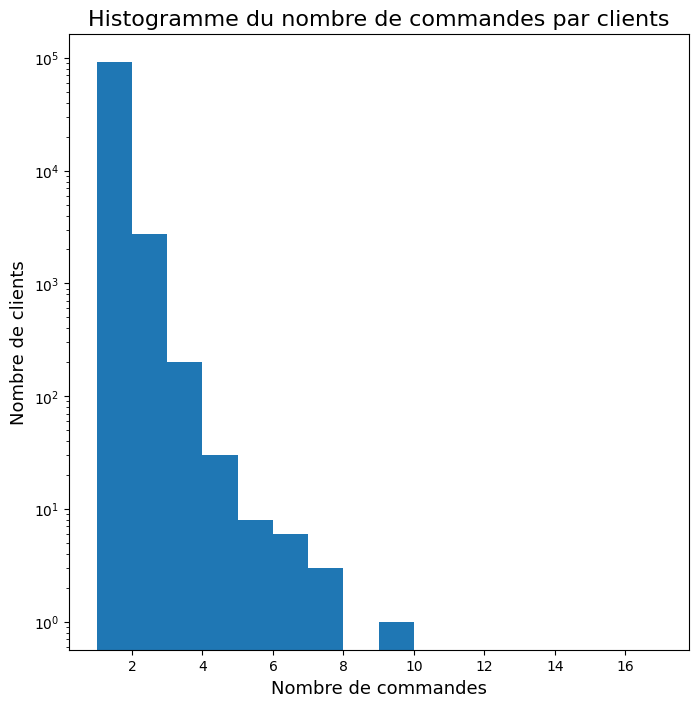

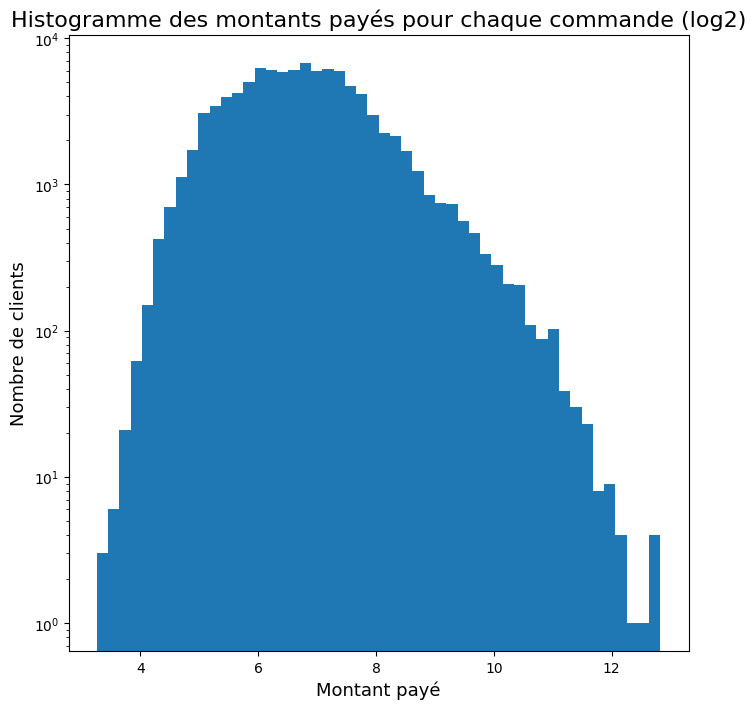

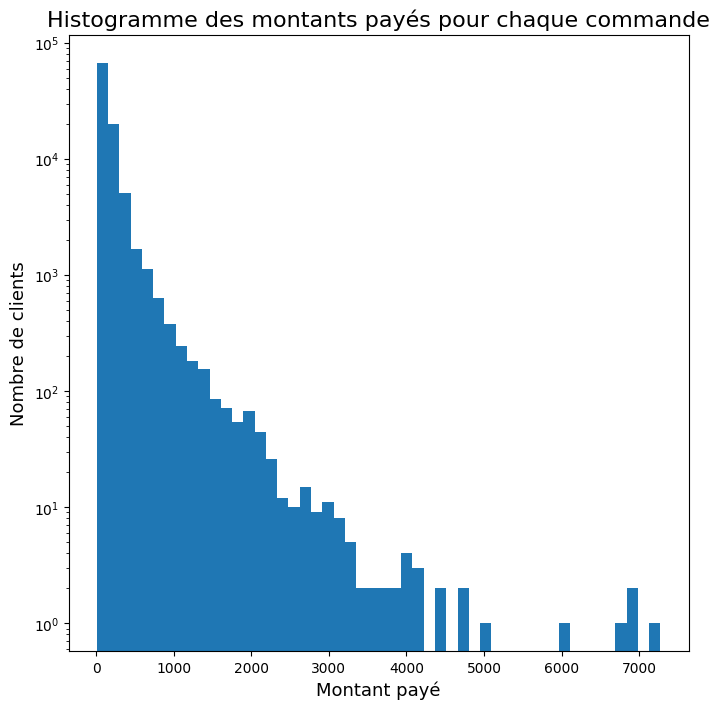

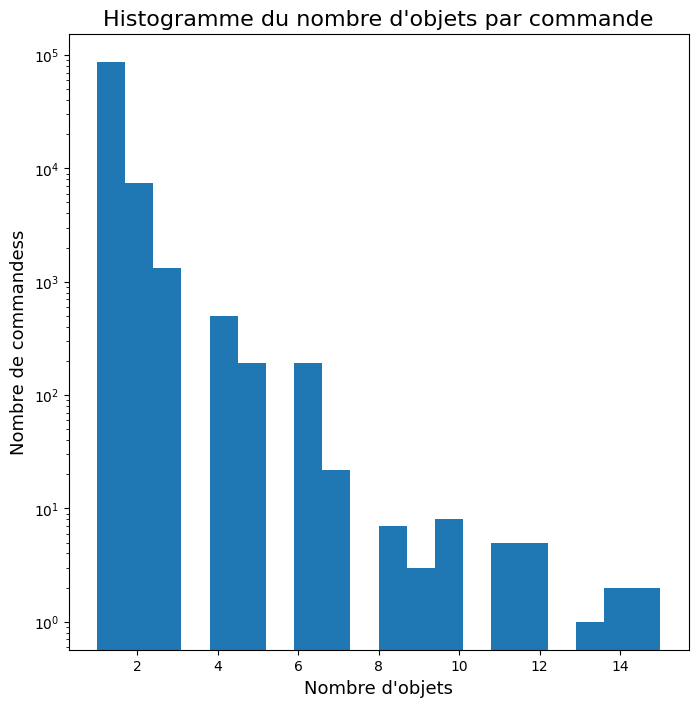

In [60]:
# histogramme du nbre de commandes (1 seul client a fait 17 commandes, un seul à 9 aussi -> outliers)
fig, ax = plt.subplots(figsize=(8, 8))
b = df_allData.drop_duplicates(subset="customer_unique_id")['nbr_orders']
fig = plt.hist(b, log=True, bins=range(1, 18))
ax.set_title('Histogramme du nombre de commandes par clients', size=16)
plt.xlabel('Nombre de commandes', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_nb_commandes_NoOutliers.png",
            bbox_inches='tight')
plt.show()
plt.close()

# histogramme des montants payés pour chaque commande livrée, log2
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = np.log2(
    df_allData[df_allData.order_status == 'delivered']['total_pay'])
plt.hist(df_delivered, log=True, bins=50)
ax.set_title('Histogramme des montants payés pour chaque commande (log2)', size=16)
plt.xlabel('Montant payé', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_montant_par_commande_NoOutliers.png",
            bbox_inches='tight')
plt.show()
plt.close()

# histogramme des montants payés pour chaque commande livrée
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = df_allData[df_allData.order_status == 'delivered']['total_pay']
plt.hist(df_delivered, log=True, bins=50)
ax.set_title('Histogramme des montants payés pour chaque commande',
             size=16)
plt.xlabel('Montant payé', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_montant_par_commande_LOG_NoOutliers.png",
            bbox_inches='tight')
plt.show()
plt.close()

# Nombre d'items par commandes
fig, ax = plt.subplots(figsize=(8, 8))
df_delivered = df_allData[df_allData.order_status == 'delivered']['nbr_items']
plt.hist(df_delivered, log=True, bins=20)
ax.set_title("Histogramme du nombre d'objets par commande", size=16)
plt.xlabel("Nombre d'objets", fontsize=13)
plt.ylabel('Nombre de commandess', fontsize=13)
plt.savefig("P5_cleaning/hist_nb_items_par_commande_NoOutliers.png",
            bbox_inches='tight')
plt.show()
plt.close()

### Mise en place d'une analyse RFM :
- Calcul des scores de fréquence, récence, montant
- Ajout du score de satisfaction

In [15]:
df_SelectedData = df_allData[df_allData.order_status == 'delivered'][[
    'customer_unique_id', 'order_id', 'total_pay', 'nbr_items',
    'purchases_month'
]]
df_SelectedData.sort_values(by=['purchases_month'])

,customer_unique_id,order_id,total_pay,nbr_items,purchases_month
37707,4910006053f92928b62910d568d4ad1e,5c5c9fde60ffb741545cf2608e8c12ca,613.78,1.0,2016-10
30002,9783afad41afa667522bf03656c516f3,48c43415ea1c4af9afa92542183b6e55,33.52,1.0,2016-10
87845,746c7bded4ed70487bf7d6461e9f855a,de8f4a82099fe4fa6bcb8952ca51420f,64.83,1.0,2016-10
89469,a36dfd7f887f03e4818a77b11784236e,e2eaf909eb6ba881117aa407992a5ffb,115.22,1.0,2016-10
91730,0a02ba4243b1b0e048a3841d5758d113,e9555dc20eba7e4e62210df1f438ea00,143.40,2.0,2016-10
...,...,...,...,...,...
59673,178cde68bfabcfa313026d0093c134aa,95149a14172495a0aef0ac5c59f95d1c,252.07,1.0,2018-08
26840,44a64df27a7de57ff4df2aa426acabcf,4123f9252f0d0572f075dbb5a95d9cc6,99.16,1.0,2018-08
94196,56929b4cf5b306902176697e4b487528,f0134bd71e6bbd312d86f1f073d60b72,63.46,1.0,2018-08
59749,2b8910e795f40ad6916339765ba12c60,9546aa638d07ac340a91c59b0b2dee96,206.51,1.0,2018-08


In [16]:
dates = pd.to_datetime(df_SelectedData.purchases_month)

In [17]:
date_max = dates.max()
date_min = dates.min()
print(date_max)
print(date_min)

2018-08-01 00:00:00
2016-10-01 00:00:00


In [18]:
from dateutil import relativedelta
from time import sleep
from tqdm import tqdm

tmp = False

month = []
if tmp:

    for ordr in tqdm(df_SelectedData.order_id.unique()):
        date_min = pd.to_datetime(df_SelectedData[
            df_SelectedData.order_id == ordr]['purchases_month'].iloc[0])

        delta = relativedelta.relativedelta(date_max, date_min)
        month.append(delta.months + (delta.years * 12))

    df_SelectedData['diff_month'] = month
    df_SelectedData.to_csv('DIFF_MONTH.csv')

else:
    df_tmp = pd.read_csv("DIFF_MONTH.csv", sep=",")
    df_SelectedData['diff_month'] = df_tmp['diff_month']

In [19]:
interval = 4  #nbre de mois dans chaque période

df_SelectedData['N'] = 0
df_SelectedData.loc[df_SelectedData['diff_month'] < interval, 'N'] = 1

df_SelectedData['N-1'] = 0
df_SelectedData.loc[(df_SelectedData['diff_month'] > interval) &
                    (df_SelectedData['diff_month'] < 2 * interval), 'N-1'] = 1

df_SelectedData['N-2'] = 0
df_SelectedData.loc[(df_SelectedData['diff_month'] > 2 * interval) &
                    (df_SelectedData['diff_month'] < 3 * interval), 'N-2'] = 1

df_SelectedData['N-3'] = 0
df_SelectedData.loc[(df_SelectedData['diff_month'] > 3 * interval) &
                    (df_SelectedData['diff_month'] < 4 * interval), 'N-3'] = 1

df_SelectedData['N-4'] = 0
df_SelectedData.loc[(df_SelectedData['diff_month'] > 4 * interval) &
                    (df_SelectedData['diff_month'] < 5 * interval), 'N-3'] = 1

In [20]:
#Somme des commandes par clients par période
df_finalData = df_SelectedData.groupby(by=['customer_unique_id']).sum()[[
    'N', 'N-1', 'N-2', 'N-3', 'N-4'
]]
df_finalData.to_csv('somme_commandes_par_période.csv')
df_finalData.sort_values(by='N')

,N,N-1,N-2,N-3,N-4
customer_unique_id,,,,,
7fc639763b7efd44b1e6414d294da00e,0,0,1,0,0
9d9b2bcb6155c920fa1c3f132f2755f5,0,0,0,0,0
9d9ab3b77f0416765b3fbedf94a942a4,0,1,0,0,0
9d98ffc3321d84cd4801a073b3f1a2bf,0,0,0,0,0
9d96ad6d5b8b75dd83e9bd2da641e9a0,0,0,1,0,0
...,...,...,...,...,...
63387fd3e05eab4e51cf704f233db5a2,3,0,0,0,0
3d740e7cbf7e5b18027f204bd01b0be4,3,0,0,0,0
bb58670190dba4e9b320f84cb98317a3,4,0,0,1,0


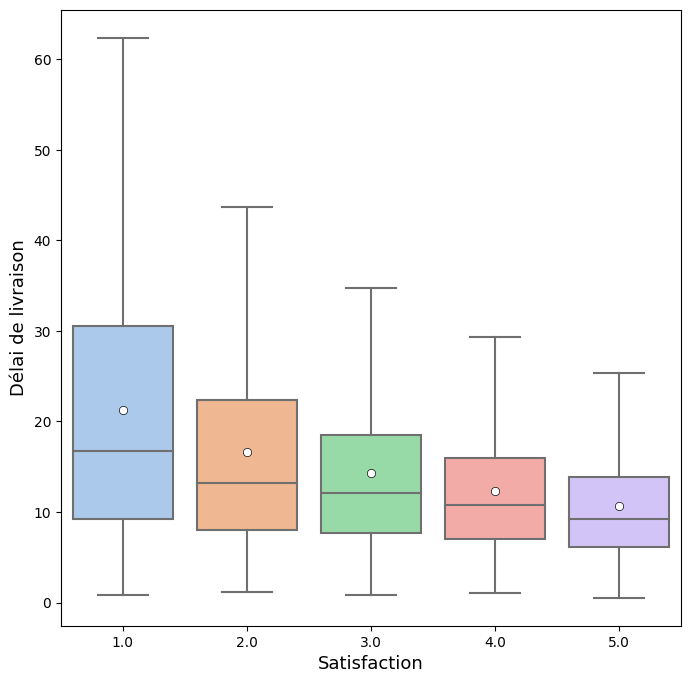

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
df_allData["order_purchase_timestamp"] = pd.to_datetime(
    df_allData["order_purchase_timestamp"])
df_allData["order_delivered_customer_date"] = pd.to_datetime(
    df_allData["order_delivered_customer_date"])

df_allData["DelaiLivraison"] = (df_allData["order_delivered_customer_date"] -
                                df_allData["order_purchase_timestamp"])
df_allData["DelaiLivraison"] = df_allData["DelaiLivraison"].apply(
    lambda x: x.total_seconds())
df_allData["DelaiLivraison"] = round(
    (df_allData["DelaiLivraison"] / 3600) / 24, 2)
sns.boxplot(y="DelaiLivraison",
            x='review_score',
            data=df_allData,
            showfliers=False,
            palette='pastel')

mean = df_allData.groupby('review_score').mean()
sns.scatterplot(x=mean.index - 1,
                y=mean.DelaiLivraison,
                color='w',
                edgecolor='k')
plt.xlabel('Satisfaction', fontsize=13)
plt.ylabel('Délai de livraison', fontsize=13)
plt.savefig("P5_cleaning/ReviewScore_par_DelaiLivraison.png",
            bbox_inches='tight')

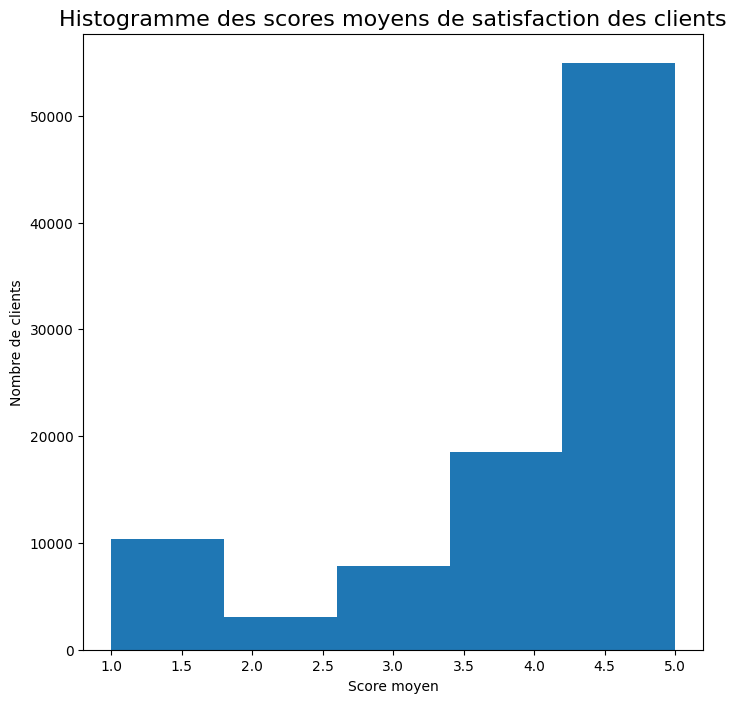

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
mean_rev = df_allData.drop_duplicates(
    subset='order_id').groupby('customer_unique_id').mean()['review_score']
plt.hist(mean_rev.sort_values().dropna(), bins=5)
ax.set_title('Histogramme des scores moyens de satisfaction des clients',
             size=16)
plt.xlabel('Score moyen')
plt.ylabel('Nombre de clients')
plt.savefig("P5_cleaning/hist_satisfactionMoyenne.png", bbox_inches='tight')
plt.show()
plt.close()

In [23]:
mean_rev.rename('mean_review_score', inplace=True)
df_finalData = df_finalData.join(mean_rev)

In [24]:
#df_SelectedData['satisf_moyenne']=df_SelectedData.set_index('customer_unique_id').join(a.groupby('customer_unique_id').mean()['review_score'])
#a.groupby('customer_unique_id').mean()['review_score']
len(df_SelectedData.customer_unique_id.unique())

93352

In [25]:
df_finalData

,N,N-1,N-2,N-3,N-4,mean_review_score
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,0,0,0,0,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,1,0,0,0,0,4.0
0000f46a3911fa3c0805444483337064,0,0,0,0,0,3.0
0000f6ccb0745a6a4b88665a16c9f078,0,0,0,1,0,4.0
0004aac84e0df4da2b147fca70cf8255,0,0,0,0,0,5.0
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1,0,0,0,0,5.0
fffea47cd6d3cc0a88bd621562a9d061,0,0,0,0,0,4.0
ffff371b4d645b6ecea244b27531430a,0,0,0,0,0,5.0


7571.63


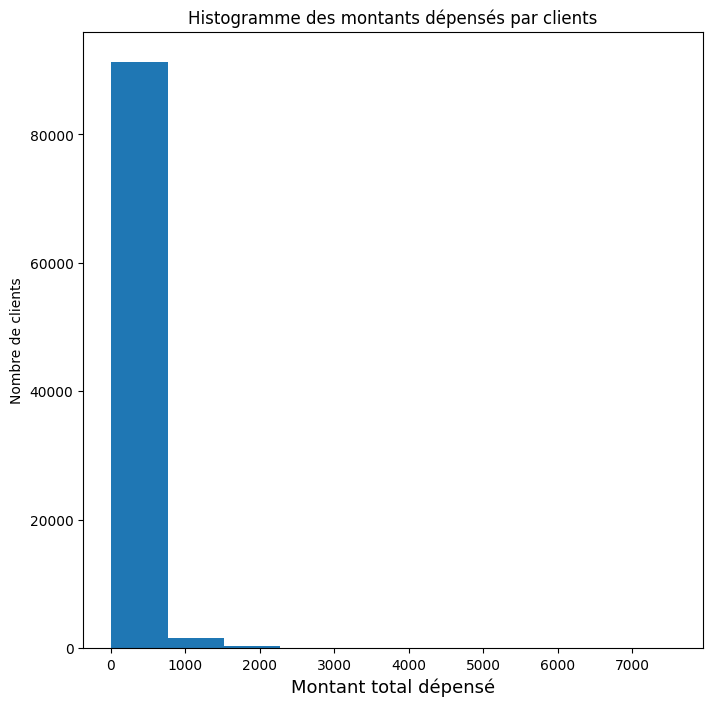

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
total_spent = df_SelectedData.groupby(
    'customer_unique_id').sum()['total_pay'].rename('total_spent')
df_finalData = df_finalData.join(total_spent)
plt.hist(df_finalData['total_spent'])
plt.title('Histogramme des montants dépensés par clients')
plt.xlabel('Montant total dépensé', fontsize=13)
plt.ylabel('Nombre de clients')
plt.savefig("P5_cleaning/hist_montantsDepenses.png", bbox_inches='tight')

print(df_finalData.total_spent.max())

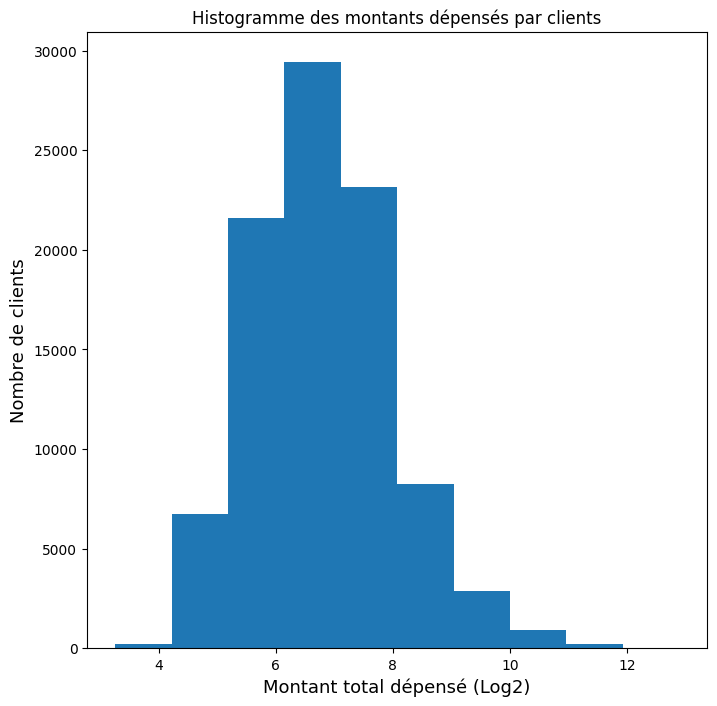

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
df_finalData['total_spent_log'] = np.log2(df_finalData['total_spent'])
plt.hist(df_finalData.total_spent_log)
plt.title('Histogramme des montants dépensés par clients')
plt.xlabel('Montant total dépensé (Log2)', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/hist_montantsDepenses_LOG.png", bbox_inches='tight')

In [28]:
# récence : Plus le client a commandé récemment, plus son score est élevé
intervales = {'N': 5, 'N-1': 4, 'N-2': 3, 'N-3': 2, 'N-4': 1}

df_finalData['Recence'] = 0

for cust in tqdm(df_finalData.index):
    for intv in intervales:

        if df_finalData[intv][cust] == 0:
            continue

        else:
            df_finalData['Recence'][cust] = intervales[intv]
            break

  0%|                                                         | 0/93352 [00:00<?, ?it/s]/tmp/ipykernel_309833/1299210185.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_finalData['Recence'][cust] = intervales[intv]
100%|███████████████████████████████████████████| 93352/93352 [00:15<00:00, 6058.73it/s]


In [29]:
# Frequence : savoir si le client a commandé au moins une fois dans les périodes concernées
intervales = ['N', 'N-1', 'N-2', 'N-3', 'N-4']
df_finalData['Frequence'] = 0

for cust in tqdm(df_finalData.index):
    df_finalData.loc[cust, 'Frequence'] = np.count_nonzero(
        df_finalData.loc[cust, intervales], axis=0)

100%|███████████████████████████████████████████| 93352/93352 [00:51<00:00, 1807.19it/s]


In [30]:
df_finalData.sort_values(by='Frequence')

,N,N-1,N-2,N-3,N-4,mean_review_score,total_spent,total_spent_log,Recence,Frequence
customer_unique_id,,,,,,,,,,
ffffd2657e2aad2907e67c3e9daecbeb,0,0,0,0,0,5.000000,71.56,6.161081,0,0
6f07efa50aae0251769838774e386d46,0,0,0,0,0,5.000000,86.28,6.430954,0,0
6f0951d261fc405f12caba921e175169,0,0,0,0,0,5.000000,54.52,5.768714,0,0
347d455aec6fb3e17963a30b8f29f184,0,0,0,0,0,5.000000,167.60,7.388878,0,0
347c4a952f101548d5a01e17ab9a9a26,0,0,0,0,0,4.000000,24.37,4.607034,0,0
...,...,...,...,...,...,...,...,...,...,...
db8e4be2382fc04a998f0f1875767ee1,1,1,1,1,0,5.000000,628.28,9.295264,5,4
271d3cdd872021b1b6669ad93e8b856b,1,1,1,1,0,5.000000,777.42,9.602550,5,4
3bab949ef05da8e9b3cfd541b6af0ffd,1,1,2,1,0,5.000000,1166.64,10.188144,5,4


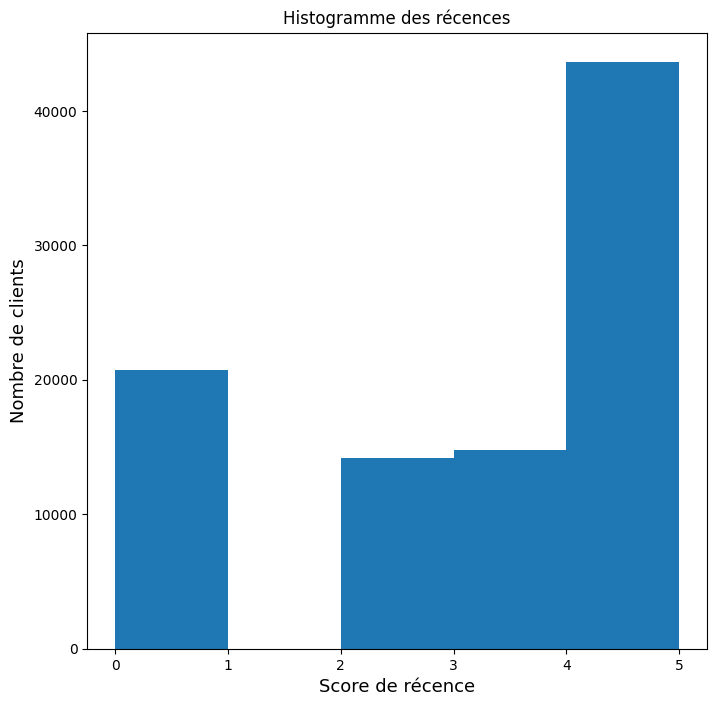

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(df_finalData.Recence, bins=5)
plt.title('Histogramme des récences')
plt.xlabel('Score de récence', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/FinalData_Recence.png", bbox_inches='tight')

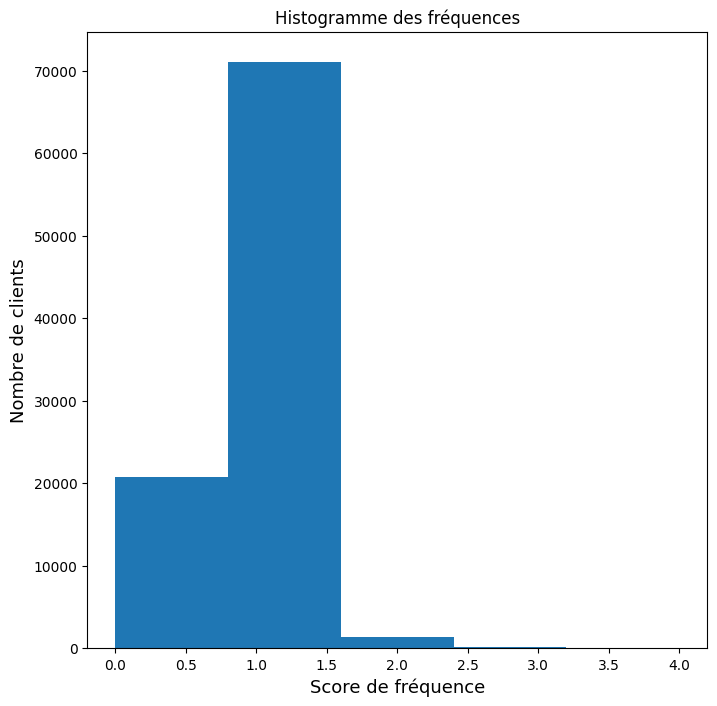

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(df_finalData.Frequence, bins=5)
plt.title('Histogramme des fréquences')
plt.xlabel('Score de fréquence', fontsize=13)
plt.ylabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/FinalData_frequence.png", bbox_inches='tight')

In [33]:
df_finalData.drop(columns=intervales, inplace=True)
df_finalData.dropna(inplace=True)
df_finalData.to_csv(r'input_clustering.csv')

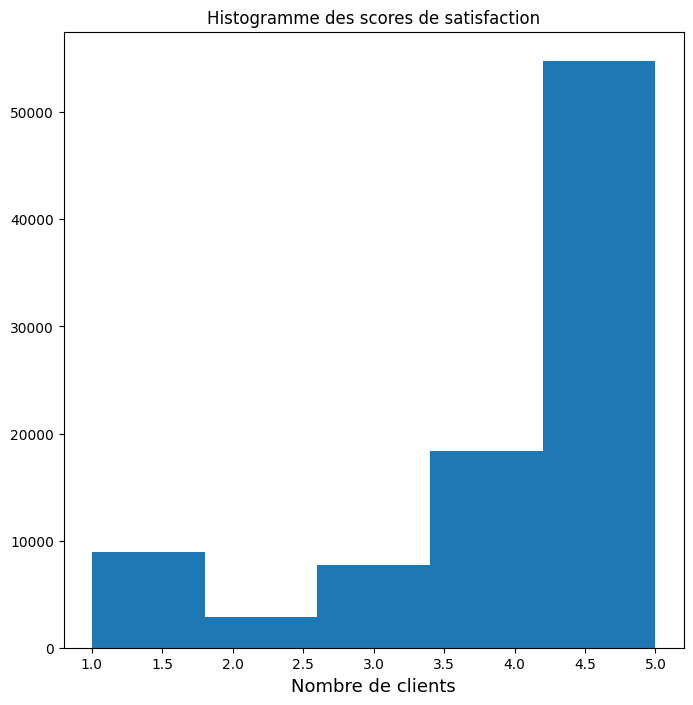

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(df_finalData.mean_review_score, bins=5)
plt.title('Histogramme des scores de satisfaction')
plt.xlabel('Score de satisfaction', fontsize=13)
plt.xlabel('Nombre de clients', fontsize=13)
plt.savefig("P5_cleaning/FinalData_Satisfaction.png", bbox_inches='tight')

In [35]:
# Sauvegarde de toutes les commandes avec les informations nécessaires pour l'ARI
timestamps = df_allData[[
    'customer_id', "customer_unique_id", "order_purchase_timestamp",
    "total_pay", "review_score"
]]

timestamps["order_purchase_timestamp"] = pd.to_datetime(
    timestamps.order_purchase_timestamp).dt.date

timestamps.set_index('customer_id').to_csv('timestamps.csv')

/tmp/ipykernel_309833/3148256669.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  timestamps["order_purchase_timestamp"] = pd.to_datetime(
